# Detecção de Alturas

## Objetivos
Ao final desta unidade, o aluno 
1. **Comprender** a relação entre o fenômeno perceptual da altura e o fenômeno físico da frequência fundamental
1. **Aplicar** algoritmos de processamento de sinais para detecção de frequência fundamental e entender suas limitações
1. **Analisar** o desempenho de algoritmos para detecção de frequências fundamentais em condições não-ideais

## Pré-requisitos

Antes de começar a discussão desta unidade, o aluno deve estar tranquilo com os seguintes conceitos:

### 1. Convolução no Domínio do Tempo e Multiplicação no Domínio da Frequência

Se um sinal $y[n]$ é obtido pela convolução entre uma entrada $x[n]$ e uma resposta ao impulso $h[n]$, então temos que sua Transformada de Fourier é calculada pela multiplicação entre as Transformadas de Fourier da entrada e do impulso, ou seja:
$$ y[m] = \sum _{m=-M}^M x[m]h[n-m] \iff  Y[k] = X[k]H[k].$$

### 2. Cálculo de somatórias por computador

Para calcular uma somatória num programa de computador, é possível utilizar um laço *for*. Assim, o resultado da expressão:
$$y[n] = \sum _{m=0}^n \frac{x[m]}{n}$$

pode ser calculado pelo programa:

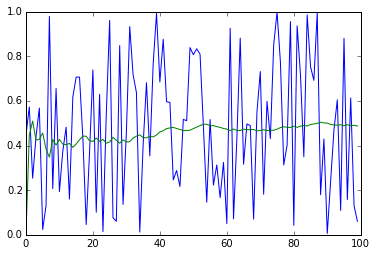

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

n_max = 100 # Este valor é arbitrário
y = np.zeros(n_max)
x = np.random.random(n_max)

for n in xrange(n_max):
    for m in xrange(n):
        y[n] += x[m]/float(n)

plt.figure()
plt.plot(x)
plt.plot(y)
plt.show()

### 3. Cordas e tubos vibrantes oscilam em modos próprios
Cordas e tubos vibrantes oscilam em diversas frequências, todas múltiplas de uma frequência fundamental $f_0$. Por este motivo, o sinal de áudio resultante desta vibração pode ser razoavelmente bem descrito por uma Série de Fourier, na forma:

$$x(t) = \sum_{m=1}^M a_m \cos(2 \pi m f_0 t + \phi_m).$$

### 4. Conceito matemático de periodicidade de um sinal

Um sinal $x(t)$ é periódico com período $\tau$ se $x(t) = x(t-\tau)$ para todo $t$. 


## Auto-correlação

A auto-correlação de um sinal é um sinal de tamanho igual ao sinal original, calculado por:
$$r_{x}[k] = \sum_{n=-\infty}^{\infty} x[n]x[n+k].$$

A auto-correlação representa a energia de um sinal multiplicado por ele mesmo e deslocado $k$ amostras. Trata-se de um sinal que é máximo para $k=0$ e que decai com o aumento de $k$.

Na prática, sinais $x[n]$ sempre têm uma duração conhecida. Por isso, os limites da somatória sempre são modificados de forma a contemplar essa duração conhecida.

Vejamos o que acontece quando calculamos algumas auto-correlações:

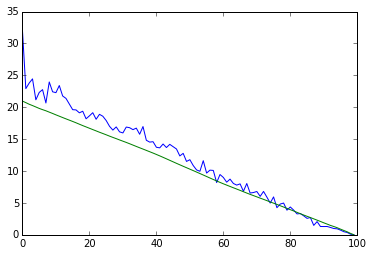

In [2]:
def acc(x):
    """Calcula a auto-correlacao de um sinal x[n]"""
    r = np.zeros(x.shape)
    for k in xrange(len(r)):
        for n in xrange(len(x)):
            if (n+k) < len(x): # Esta condicional evita acessar elementos x[m] para m < 0
                r[k] += x[n] * x[n+k]
    return r
    
rx = acc(x)
ry = acc(y)
plt.figure()
plt.plot(rx)
plt.plot(ry)
plt.show()

Veja que, neste caso, há progressivamente menos amostras não-nulas no sinal de auto-correlação. Poderíamos corrigir isso utilizando uma janela deslizante com a metade do tamanho de $x[n]$, e restringindo nosso cálculo à metade do comprimento de $x[n]$.

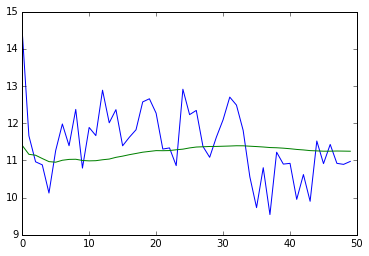

In [30]:
def acc2(x):
    """Calcula a auto-correlacao de um sinal x[n]"""
    r = np.zeros(len(x)/2)
    for k in xrange(len(r)):
        for n in xrange(len(r)):
            if (n+k) > 0: # Esta condicional evita acessar elementos x[m] para m < 0
                r[k] += x[n] * x[n+k]
    return r
    
rx = acc2(x)
ry = acc2(y)
plt.figure()
plt.plot(rx)
plt.plot(ry)
plt.show()

Uma propriedade importante da auto-correlação é que se $x(t)$ é periódico então sua autocorrelação $r_x(t)$ também é periódica, com mesmo período. Veja o que acontece quando geramos uma onda quadrada e calculamos sua auto-correlação:

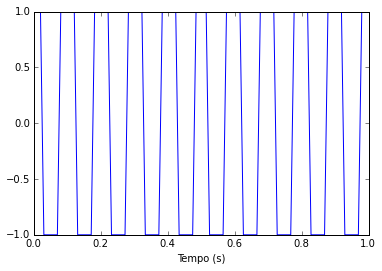

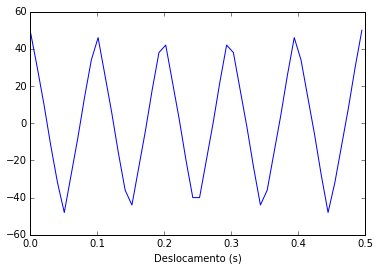

In [36]:
t = np.linspace(0, 1, 100)
x = np.sign( np.cos(2*np.pi*10*t))
r = acc2(x)

plt.figure()
plt.plot(t,x)
plt.xlabel('Tempo (s)')
plt.show()

plt.figure()
plt.plot(t[0:len(r)], r)
plt.xlabel('Deslocamento (s)')
plt.show()

Verificamos que $r_x$ apresenta picos espaçados de 0.1s, o que corresponde ao período fundamental de nosso sinal $x[n]$. Portanto, precisamos de algum algoritmo para encontrar o primeiro pico da autocorrelação que não seja o correspondente ao deslocamento zero. Embora existam muitas propostas na literatura, é possível fazer o seguinte:

1. Calcular um sinal $r'_x[n] = r_x[n] - r_x[n/2]$, correspondente a sobreamostrar a autocorrelação de um fator de 2 e então subtrair o resultado do original
2. Multiplicar $r'_x[n]$ por uma rampa decrescente, eliminando picos indesejados
3. Encontrar o máximo do sinal resultante

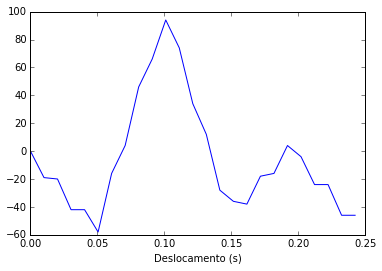

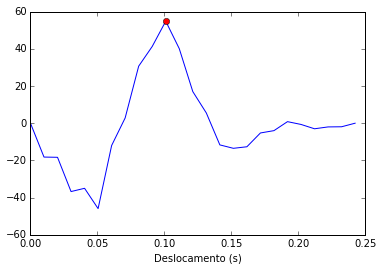

In [42]:
def upsample_subtract(r):
    r2 = np.zeros(len(r)/2)
    for n in xrange(len(r2)):
        r2[n] = r[n]-r[n/2]
    return r2

r2 = upsample_subtract(r)

plt.figure()
plt.plot(t[0:len(r2)], r2)
plt.xlabel('Deslocamento (s)')
plt.show()

r2 *= np.linspace(1, 0, len(r2))

t0 = np.argmax(r2)

plt.figure()
plt.plot(t[0:len(r2)], r2)
plt.plot(t[t0], r2[t0], 'ro')
plt.xlabel('Deslocamento (s)')
plt.show()


Neste ponto, portanto, temos um algoritmo capaz de estimar o período fundamental em um pequeno trecho contendo uma janela de um sinal periódico. Vamos melhorá-lo.

## Cálculo no domínio da frequência
Para o cálculo de cada amostra da auto-correlação, é preciso realizar $N$ somas, onde $N$ é o tamanho do sinal original $x[n]$. Como são $N$ amostras, então calcular uma auto-correlação precisa de $O(N^2)$ cálculos, o que pode se tornar um problema. Porém, podemos re-escrever a auto-correlação como:
$$r_{x}[k] = \sum_{n=-\infty}^{\infty} x[n]x[n+k]. = \sum_{n=-\infty}^{\infty} x[n]x[n-(-k)],$$
mostrando que o cálculo da auto-correlação, na verdade, é uma convolução de um sinal com ele mesmo. Portanto, a auto-correlação pode ser calculada no domínio da frequência, reduzindo a sua complexidade computacional para $O(n \log_2(n))$, dando origem ao seguinte algoritmo para calculo do periodo fundamental:

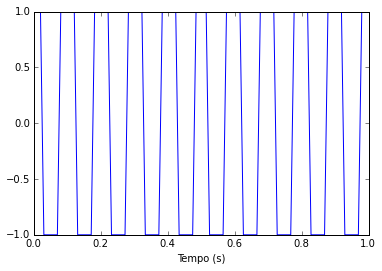

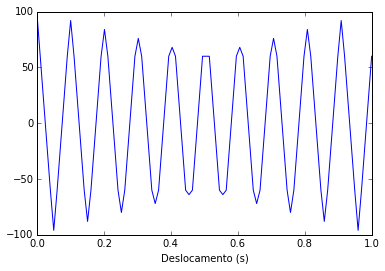

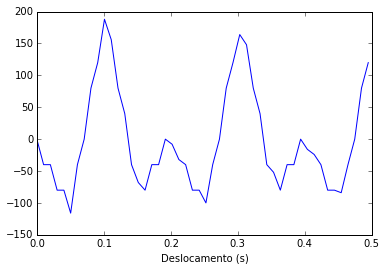

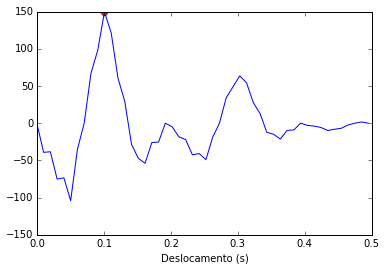

In [46]:
def acc_fd(x):
    X = np.abs(np.fft.fft(x))
    r = np.real(np.fft.ifft(X*X))
    return r

r = acc_fd(x)
plt.figure()
plt.plot(t,x)
plt.xlabel('Tempo (s)')
plt.show()

plt.figure()
plt.plot(t[0:len(r)], r)
plt.xlabel('Deslocamento (s)')
plt.show()


r2 = upsample_subtract(r)

plt.figure()
plt.plot(t[0:len(r2)], r2)
plt.xlabel('Deslocamento (s)')
plt.show()

r2 *= np.linspace(1, 0, len(r2))

t0 = np.argmax(r2)

plt.figure()
plt.plot(t[0:len(r2)], r2)
plt.plot(t[t0], r2[t0], 'ro')
plt.xlabel('Deslocamento (s)')
plt.show()

Assim, podemos consolidar nosso algoritmo numa única função, na forma:

In [53]:
def t0_acc(x):
    """Retorna o periodo fundamental de x, em amostras"""
    X = np.abs(np.fft.fft(x))
    r = np.real(np.fft.ifft(X*X))
    r2 = np.zeros(len(r)/2)
    for n in xrange(len(r2)):
        r2[n] = r[n]-r[n/2]
    r2 *= np.linspace(1, 0, len(r2))
    t0 = np.argmax(r2)
    return t0

## Aplicação em sinais reais

Até o momento, aplicamos o detector de frequências fundamentais apenas em sinais fictícios. Gostaríamos de aplicá-lo em sinais de áudio reais. Para fazer isso, é preciso lembrar que uma mesma frequência fundamental não será adequada para descrever um sinal de áudio inteiro, mas, dentro de uma pequena janela (de 23ms, por exemplo), é pouco provável que a frequência fundamental mude. Também, precisamos lembrar que o algoritmo usando autocorrelação requer uma janela que seja pelo menos duas vezes maior que o período fundamental que será medido. Assim, temos:

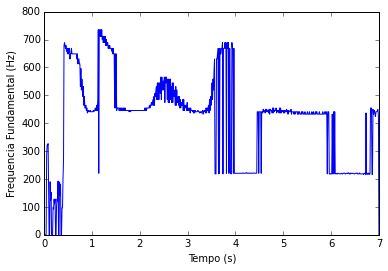

In [76]:
%matplotlib inline
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import IPython.lib.display as display 

fname = 'audio/piano.wav'
rate, data = scipy.io.wavfile.read(fname)
data = data.astype(np.float)

t0 = 0
window = 1024
step = 512
f0 = []
while t0+window < len(data):
    per_fun = t0_acc(data[t0:t0+window])
    if per_fun > 2:
        per_fun /= float(rate)
        f0.append(1./per_fun)
    else:
        f0.append(0)
    t0 += step

t = np.linspace(0, len(data)/rate, len(f0))
plt.plot(t,f0)
plt.ylabel('Frequencia Fundamental (Hz)')
plt.xlabel('Tempo (s)')
plt.show()

display.Audio(fname)

Podemos perceber que:
1. O algoritmo se comporta de forma imprevisível no silêncio que precede a nota musical,
1. Nosso algoritmo está sujeito a diversos erros de oitava (veja como ele oscila entre 440 Hz  e 220 Hz entre 4s e 7s),
1. Há alguns comportamentos imprevisíveis pouco antes da marca de 4 segundos.

Vamos ver o que acontece ao processarmos um glissando:

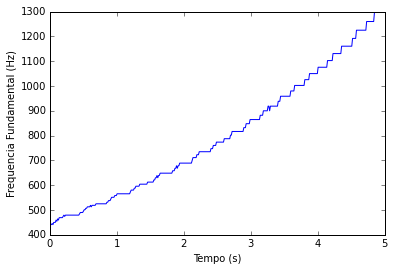

In [68]:
fname = 'audio/chirp.wav'
rate, data = scipy.io.wavfile.read(fname)
data = data.astype(np.float)

t0 = 0
window = 1024
step = 512
f0 = []
while t0+window < len(data):
    per_fun = t0_acc(data[t0:t0+window])
    if per_fun > 2:
        per_fun /= float(rate)
        f0.append(1./per_fun)
    else:
        f0.append(0)
    t0 += step

t = np.linspace(0, len(data)/rate, len(f0))
plt.plot(t,f0)
plt.ylabel('Frequencia Fundamental (Hz)')
plt.xlabel('Tempo (s)')
plt.show()

display.Audio(fname)

O sistema parece ter se comportado um pouco melhor. Porém, veja que, ao invés de estimar uma curva crescente, na verdade estimamos uma "escada". Isso acontece porque nosso sistema de detecção tem precisão finita.

Por fim, vamos tentar rodar o algoritmo em um solo de Blues. Adicionalmente, para esta análise, converteremos nossas frequências para números MIDI:

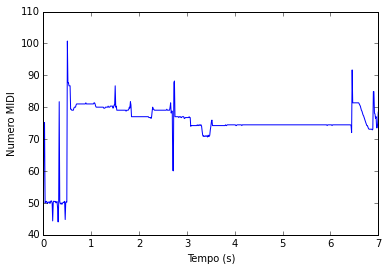

In [77]:
fname = 'audio/bbking.wav'
rate, data = scipy.io.wavfile.read(fname)
data = data.astype(np.float)

t0 = 0
window = 1024
step = 512
f0 = []
while t0+window < len(data):
    per_fun = t0_acc(data[t0:t0+window])
    if per_fun > 2:
        per_fun /= float(rate)
        f0.append(69+12*np.log2(1./(per_fun*440)))
    else:
        f0.append(0)
    t0 += step

t = np.linspace(0, len(data)/rate, len(f0))
plt.plot(t,f0)
plt.ylabel('Numero MIDI')
plt.xlabel('Tempo (s)')
plt.show()

display.Audio(fname)

Neste caso, exceto pelos comportamentos anômalos nos ataques (que são regiões em que tipicamente não vemos comportamento harmônico), o algoritmo parece ter retornado informações bastante precisas.

# Exercícios

1. Analise o algoritmo de auto-correlação. Verifique que, da forma que foi enunciada neste texto, ele tem uma precisão finita, dada pela diferença de tempo entre duas amostras. Considerando uma taxa de amostragem de 44100 Hz:
 1. Calcule a precisão do algoritmo, em segundos (para o período fundamental) e em Hz (para a frequência fundamental).
 1. Mostre qual é a máxima frequência que pode ser analisada pelo algoritmo antes que a precisão do algoritmo seja insuficiente para discernir duas notas consecutivas, considerando a escala de igual temperamento.
1. Altere os programas acima e descreva o que acontece quando:
 1. Usam uma janela de Hanning antes de calcular a autocorrelação
 1. Usam uma quantidade diferente de amostras por janela (o dobro ou a metade do original)
1. Proponha uma estrutura em alto nível para um afinador automático de violão. Ele deve informar ao usuário qual corda foi tocada e indicar se deve ser afinada mais aguda ou mais grave que a posição atual. Qual é a frequência de amostragem que o seu afinador deve ter para que não permita uma desafinação maior que 50 cents em nenhuma das cordas?
1. Opcional para a graduação: procure pelo artigo : *A. de Cheveigné and H. Kawahara. YIN, a fundamental frequency estimator for speech and music. The Journal of the Acoustical Society of America, 111:1917, 2002*.
 1. Os autores propõem detectar a frequência fundamental usando uma técnica alternativa à auto-correlação. Qual é essa técnica?
 1. Como eles testam essa nova técnica?
 1. Quais são os resultados? Como a nova técnica se compara a usar a autocorrelação?